# Self-Driving Car Nanodegree
# Vehicle Detection

In this project we will attempt to detect vehicles in a video frame. Once again we will be using classic computer vision techniques to extract features using Histogram of Oriented Gradients (HOG), train a linear support vector classifier, and then use sliding windows to apply the trained classifier to detect vehicles in an image.

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Dataset

Examples of vehicles and non-vehicles were collected from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html) and the [KITTI vision benchmark](http://www.cvlibs.net/datasets/kitti/). The [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) collections should be downloaded and unzipped into this project directory.

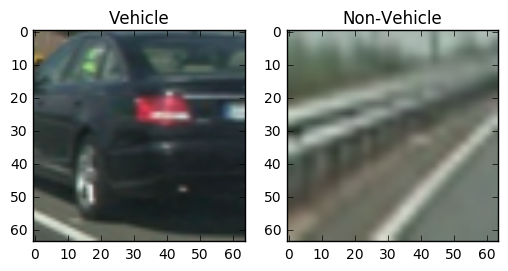

In [2]:
# Plot samples of vehicle and non-vehicle images.
example_vehicle = cv2.imread('vehicles/GTI_Right/image0000.png')
example_non_vehicle = cv2.imread('non-vehicles/GTI/image8.png')

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(example_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(cv2.cvtColor(example_non_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')

### Feature Extraction

The standard RGB colorspace used to display images on computer screens is not necessarily the best scheme to use for image recognition. For this project, we will instead use the YUV colorspace. The YUV colorspace proved to have the best classification accuracy among several that we tried (BGR, YUV, YCbCr, and HSV).

In [3]:
def colorTransform(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img

# Transform the example images to the YUV colorspace.
yuv_vehicle = colorTransform(example_vehicle)
yuv_non_vehicle = colorTransform(example_non_vehicle)

Now that the image has been loaded and converted to our preferred colorspace, we can extract the HOG features for each training image. Using the HOG features allows us to consider a fingerprint of the image that still allows some variability in the actual pixels.

Here we will bucket the HOG gradients into 8 buckets. Each image will be divided into cells of 8x8 pixels. The cells will be normalized into blocks of 2x2 cells. These values were chosen to balance the finding enough gradients to be able to identify a vehicle without making the dimensionality of the features too high. In particular, we note that classification accuracy continued to rise as the number of bins increased but this significantly increased the CPU and memory cost to deal with these additional features

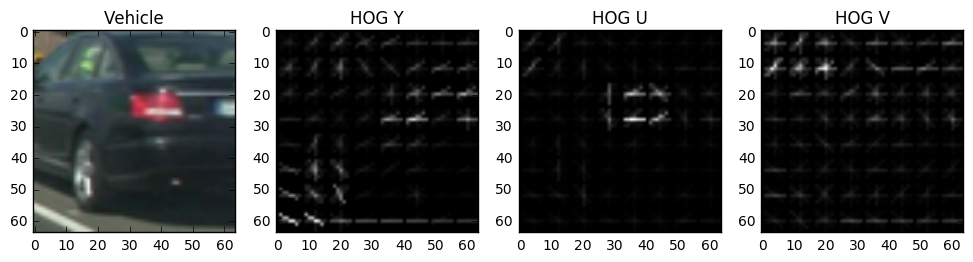

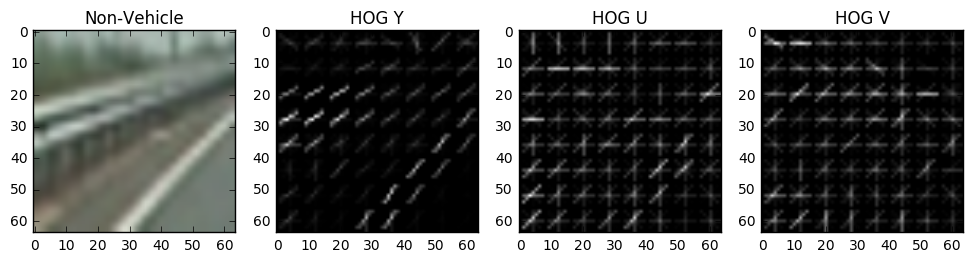

In [4]:
# HOG parameters
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(channel, orientations=HOG_ORIENTATIONS,
                                  pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                                  cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(channel, orientations=HOG_ORIENTATIONS,
                       pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                       cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

# Generate HOG visualization for example images.
hog_vehicle_y = hog_features(yuv_vehicle[:,:,0], visualise=True)
hog_vehicle_u = hog_features(yuv_vehicle[:,:,1], visualise=True)
hog_vehicle_v = hog_features(yuv_vehicle[:,:,2], visualise=True)
hog_non_vehicle_y = hog_features(yuv_non_vehicle[:,:,0], visualise=True)
hog_non_vehicle_u = hog_features(yuv_non_vehicle[:,:,1], visualise=True)
hog_non_vehicle_v = hog_features(yuv_non_vehicle[:,:,2], visualise=True)

fig = plt.figure(1, figsize=(12, 9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(example_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Vehicle')
plt.subplot(142)
plt.imshow(hog_vehicle_y, cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_vehicle_u, cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_vehicle_v, cmap='gray')
plt.title('HOG V')
fig = plt.figure(2, figsize=(12,9))
plt.subplot(141)
plt.imshow(cv2.cvtColor(example_non_vehicle, cv2.COLOR_BGR2RGB))
plt.title('Non-Vehicle')
plt.subplot(142)
plt.imshow(hog_non_vehicle_y, cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_non_vehicle_u, cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_non_vehicle_v, cmap='gray')
plt.title('HOG V')

We can now combine combine the individual transformations to extract a feature vector from an image. We experimented with using only a single channel to extract HOG features, but found that classification accuracy increased significantly by including all channels.

In [5]:
def extract_features(img):
    img = colorTransform(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

## Training the Classifier

Now that we have defined all of the helper functions to load images and extract features, we can create the feature vectors and categories from the training dataset.

In [6]:
X_all = []
y_all = []
for filename in glob.glob('vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = extract_features(img)
    X_all.append(features)
    y_all.append(True)
for filename in glob.glob('non-vehicles/*/*.png'):
    img = cv2.imread(filename)
    features = extract_features(img)
    X_all.append(features)
    y_all.append(False)

Next we will normalize the feature vectors. This will help keep the classifier from erroneously focusing on features with values of different magnitudes. It will also improve the efficiency and numerical stability of the calculations by keeping the features values small and centered around zero.

We will also save the scaler to apply the same transformations to features extracted from images when we use the classifier to detect vehicles.

In [7]:
Xscaler = StandardScaler().fit(X_all)
X_all = Xscaler.transform(X_all)

Now we will split the extracted features and labels into a training set and a test set. The training set will be used train the classifier while the test set will be used to evaluate how well the classifier will generalize to unseen data. We will perform a stratified shuffled split, which should help ensure that the split randomly selects samples while roughly preserving the proportion of vehicle and non-vehicle examples. By explicitly setting the `random_state` parameter, we can make sure that the split will be repeatable as we develop the model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=1)
X_all = None
y_all = None

With the examples now divided into a training set and a test set, we can now train the classifier. Once again, we will explicitly set the `random_state` parameter to ensure that the training results are reproduceable.

Here we have chosen to use a linear SVC classifier. This is a type of support vector machine classifier that has been optimized to work with linear kernels. The classifier will be trained using a concatenation of HOG features derived from each of the YUV channels of training images.

In [9]:
classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))
X_train = None
X_test = None
y_train = None
y_test = None

Vehicle classifier trained with test accuracy: 98.5%


## Image Processing Pipeline

In [10]:
def pipeline(img):
    return img

## Video Pipeline

Now all the steps are in place to detect vehicles in the videos.

In [11]:
def process_image():
    return (lambda img: pipeline(img))

for filename in ['test_video.mp4']:
    clip = VideoFileClip(filename)
    out = clip.fl_image(process_image())
    out.write_videofile('processed-' + filename, audio=False)

[MoviePy] >>>> Building video processed-test_video.mp4
[MoviePy] Writing video processed-test_video.mp4


 97%|█████████▋| 38/39 [00:00<00:00, 182.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-test_video.mp4 

